In [63]:
# All necessary packages will be imported here
import yfinance as yf
from sklearn.preprocessing import MinMaxScaler
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Dense,LSTM
from tensorflow.keras.models import Sequential
import tensorflow as tf
from sklearn.metrics import r2_score

In [64]:
#Extraction of dataset
data=yf.download("AAPL",start="2016-01-01", end="2024-12-31")
df=data[["Close"]].copy()
df.dropna(inplace=True)

/var/folders/zw/_94_p9x902l3mtbhy8j3qxkh0000gn/T/ipykernel_78437/3333925552.py:2: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data=yf.download("AAPL",start="2016-01-01", end="2024-12-31")
[*********************100%***********************]  1 of 1 completed


In [65]:
# Lets curate data
scaler=MinMaxScaler()
df_scaled=scaler.fit_transform(df)

In [66]:
def create_sequence(data,window_size):
    X=[]
    Y=[]
    for i in range(len(data)-window_size):
        X.append(data[i:i+window_size])
        Y.append(data[i+window_size])
    return np.array(X),np.array(Y)

In [67]:
window_size=90
X,Y=create_sequence(df_scaled,window_size)
X=X.reshape((X.shape[0],X.shape[1],1))
X_train,X_test,Y_train,Y_test=train_test_split(X,Y,test_size=0.2,random_state=42)

In [68]:
# Lets build on model
model=Sequential([
    LSTM(128,activation="tanh",return_sequences=True,input_shape=(window_size,1)),
    LSTM(64,return_sequences=True),
    LSTM(32),
    Dense(1)
])

/Users/sam/Desktop/venv/lib/python3.9/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [69]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),loss="mse")
history=model.fit(X_train,Y_train,
                 epochs=200,
                 batch_size=32,
                 validation_split=0.1,
                 verbose=1)
loss=model.evaluate(X_test,Y_test,verbose=1)
Y_pred_scaled=model.predict(X_test)
Y_pred=scaler.inverse_transform(Y_pred_scaled)
Y_test_org=scaler.inverse_transform(Y_test)
r2=r2_score(Y_pred,Y_test_org)
print(r2)


Epoch 1/200
49/49 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - loss: 0.0486 - val_loss: 8.8717e-04
Epoch 2/200
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 7.5694e-04 - val_loss: 8.6919e-04
Epoch 3/200
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 6.3858e-04 - val_loss: 8.5023e-04
Epoch 4/200
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 5.7890e-04 - val_loss: 7.8731e-04
Epoch 5/200
49/49 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - loss: 5.3996e-04 - val_loss: 7.9118e-04
Epoch 6/200
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 5.3717e-04 - val_loss: 6.3748e-04
Epoch 7/200
49/49 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - loss: 4.7311e-04 - val_loss: 7.4989e-04
Epoch 8/200
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 5.6600e-04 - val_loss: 9.3445e-04
Epoch 9/200
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 4.6372e-04 - val_loss: 5.4594e-04
Epoch 10/200
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 4.3135e-04 - val_loss: 7.8258e-04
Epoch 11/200
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 5.

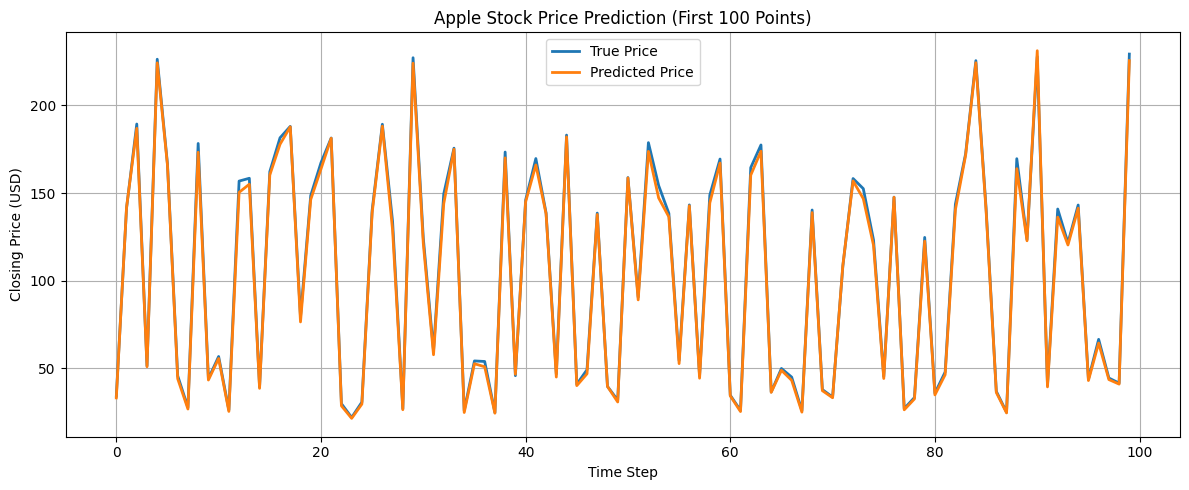

In [71]:
import matplotlib.pyplot as plt

# Plot predictions vs actual (first 100 samples for clarity)
plt.figure(figsize=(12, 5))
plt.plot(Y_test_org[:100], label='True Price', linewidth=2)
plt.plot(Y_pred[:100], label='Predicted Price', linewidth=2)
plt.title("Apple Stock Price Prediction (First 100 Points)")
plt.xlabel("Time Step")
plt.ylabel("Closing Price (USD)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [72]:
# 1. Flatten arrays
true_prices = Y_test_org.flatten()
pred_prices = Y_pred.flatten()

# 2. Compute trend direction: 1 for up, 0 for down
true_trend = (np.diff(true_prices) > 0).astype(int)
pred_trend = (np.diff(pred_prices) > 0).astype(int)

# 3. Compute trend accuracy
trend_accuracy = np.mean(true_trend == pred_trend) * 100
print(f"Trend Prediction Accuracy: {trend_accuracy:.2f}%")


Trend Prediction Accuracy: 98.62%


In [73]:
# Flatten trend arrays
true_trend = (np.diff(true_prices) > 0).astype(int)
pred_trend = (np.diff(pred_prices) > 0).astype(int)

# Create a mask for upward and downward cases
up_mask = true_trend == 1
down_mask = true_trend == 0

# Calculate accuracy for upward trend predictions
up_correct = np.sum(pred_trend[up_mask] == true_trend[up_mask])
up_total = np.sum(up_mask)
up_accuracy = (up_correct / up_total) * 100 if up_total > 0 else 0

# Calculate accuracy for downward trend predictions
down_correct = np.sum(pred_trend[down_mask] == true_trend[down_mask])
down_total = np.sum(down_mask)
down_accuracy = (down_correct / down_total) * 100 if down_total > 0 else 0

# Print both
print(f"Trend Accuracy (Upward):   {up_accuracy:.2f}%")
print(f"Trend Accuracy (Downward): {down_accuracy:.2f}%")


Trend Accuracy (Upward):   98.65%
Trend Accuracy (Downward): 98.58%
